图像读取

In [1]:
import cv2 #opencv读取的格式是BGR格式
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import easyocr
%matplotlib inline

temp_json = "fig07.json"
temp_jpg = "fig07.jpg"

img = cv2.imread(temp_jpg)
h, w, c = img.shape

In [2]:
def cv_show(name, img):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
Original = cv2.imread(temp_jpg)

In [4]:
with open(temp_json, 'r') as file:
    data = json.load(file)
    point1 = data["shapes"][0]["points"][0]
    point4 = data["shapes"][1]["points"][0]
    point2 = data["shapes"][2]["points"][0]
    point3 = data["shapes"][3]["points"][0]
    
def get_point(point):
    x = int(point[0])
    y = int(point[1])
    return (x,y)
    
src_list = [get_point(point1), get_point(point2), get_point(point3), get_point(point4)]
for i, pt in enumerate(src_list):
    cv2.circle(img, pt, 5, (0, 0, 255), -1)
    cv2.putText(img,str(i+1),(pt[0]+5,pt[1]+10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
pts1 = np.float32(src_list)

透视变换

In [5]:
pts2 = np.float32([[0, 0], [0, w - 2], [h - 2, w - 2], [h - 2, 0]])
#计算变换矩阵
matrix = cv2.getPerspectiveTransform(pts1, pts2)
#应用变换矩阵
result = cv2.warpPerspective(Original, matrix, (h, w))

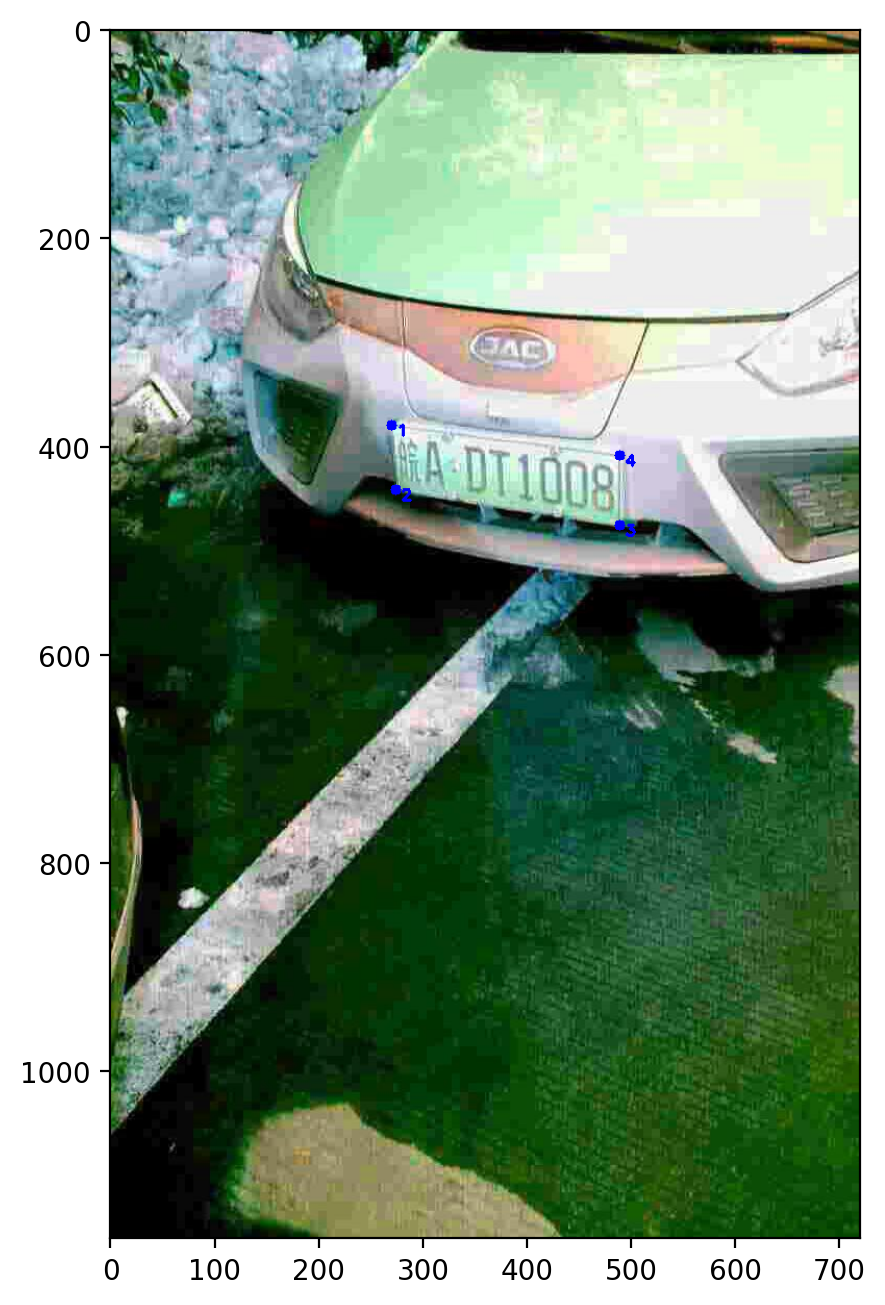

In [6]:
plt.figure(figsize=(10, 8), dpi=200)
plt.imshow(img)

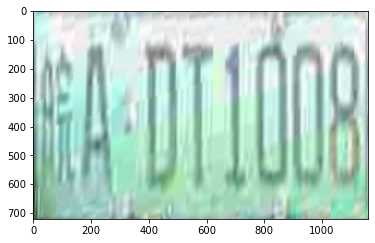

In [7]:
plt.imshow(result)

In [8]:
plate = cv2.resize(result, (480, 140))

标准车牌高为140mm，宽为440mm车牌的宽高比为3.14。

In [9]:
plt.imshow(plate)

In [10]:
gauss_plate = cv2.GaussianBlur(plate, (3,3), 0)

In [11]:
plt.imshow(gauss_plate)

In [12]:
gray_image = cv2.cvtColor(gauss_plate, cv2.COLOR_RGB2GRAY)

In [13]:
#ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)

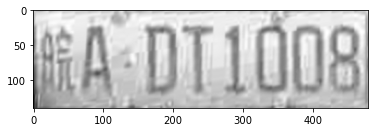

In [14]:
plt.imshow(gray_image,cmap='gray')

In [15]:
image = gray_image.copy()

In [16]:
rows = image.shape[0]
cols = image.shape[1]
image.shape

(140, 480)

In [17]:
gray_mean = np.mean(image)*0.9
gray_mean

180.42045535714288

In [18]:
for row in range(rows):
    res = 0
    for col in range(cols):
        if image[row][col] > gray_mean:
            image[row][col] = 255
        else:
            image[row][col] = 0

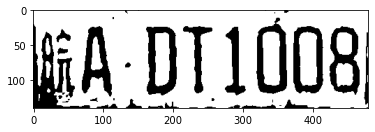

In [19]:
plt.imshow(image,cmap='gray')

In [20]:
hd = []
for row in range(rows):
    res = 0
    for col in range(cols):
        if image[row][col] == 0:
            res = res+1
    hd.append(res)

<BarContainer object of 140 artists>

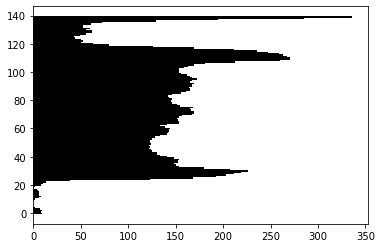

In [21]:
y = [y for y in range(rows)]
x = hd
plt.barh(y,x,color='black',height=1)

In [22]:
x = range(int(rows/2), 2, -1)
x = [*x]

In [23]:
mean = sum(hd[0:int(rows/2)])/(int(rows/2)+1)*2/3
region = []
for i in range(int(rows/2), 2, -1):
    if hd[i] < mean:
        region.append(i)
        break
        
mean = sum(hd[int(rows/2):rows])/(int(rows/2)+1)*2/3
for i in range(int(rows/2), rows):
    if hd[i] < mean:
        region.append(i)
        break

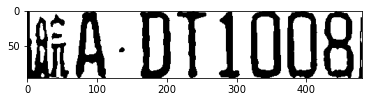

In [24]:
imageh = image[region[0]:region[1],:]
plt.imshow(imageh,cmap='gray')

In [25]:
imagev = imageh.copy()

imagev = imagev[:,10:430]
plt.imshow(imagev,cmap='gray')

reader = easyocr.Reader(['en']) # 只需要运行一次就可以将模型加载到内存中
result = reader.readtext(imagev)
result

In [26]:
rows = imagev.shape[0]
cols = imagev.shape[1]

In [27]:
hdv = []
for col in range(cols):
    res = 0
    for row in range(rows):
        if imagev[row][col] == 0:
            res = res+1
    hdv.append(res)
len(hdv)

480

<BarContainer object of 480 artists>

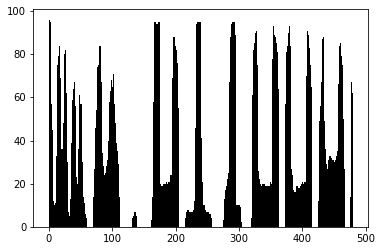

In [28]:
x = [x for x in range(cols)]
y = hdv
plt.bar(x,y,color='black',width=1)

In [29]:
mean = sum(hdv)/len(hdv)
mean

32.5375

In [30]:
for i in range(cols):
    if hdv[i] < mean/2:
        hdv[i] = 0

<BarContainer object of 480 artists>

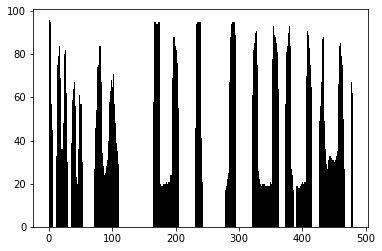

In [31]:
x = [x for x in range(cols)]
y = hdv
plt.bar(x,y,color='black',width=1)

In [32]:
regionx = []
for i in range(0, cols-1):
    if hdv[i] == 0 and hdv[i+1] != 0:
        regionx.append(i)
        break
        
for i in range(cols-1, 0, -1):
    if hdv[i] == 0 and hdv[i-1] != 0:
        regionx.append(i)
        break

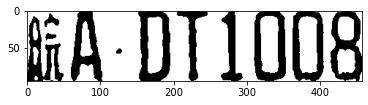

In [33]:
imagev = imageh[:,regionx[0]:regionx[1]]
plt.imshow(imagev,cmap='gray')

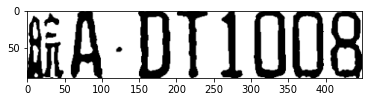

In [34]:
image = cv2.resize(imagev, (449, 90))
plt.imshow(image,cmap='gray')

In [35]:
image = 255 - image

In [36]:
image1 = image[:,0:50]
image2 = image[:,48:104]
image3 = image[:,145:191]
image4 = image[:,199:245]
image5 = image[:,250:296]
image6 = image[:,303:349]
image7 = image[:,353:399]
image8 = image[:,403:449]

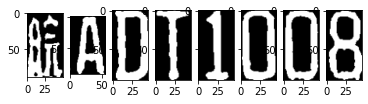

In [37]:
plate = [image1, image2, image3, image4, image5, image6, image7, image8]

for i in range(8):
    plt.subplot(1, 8, i+1), plt.imshow(plate[i], 'gray')

reader = easyocr.Reader(['en']) # 只需要运行一次就可以将模型加载到内存中
result = reader.readtext(image6)
result

In [38]:
# 模版匹配
# 准备模板(template[0-9]为数字模板；)
template = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
            'X', 'Y', 'Z',
            '藏', '川', '鄂', '甘', '赣', '贵','皖']

# '桂', '黑', '沪', '吉', '冀', '津', '晋', '京', '辽', '鲁', '蒙', '闽',
#            '宁',
#            '青', '琼', '陕', '苏', 
#            '湘', '新', '渝', '豫', '粤', '云', '浙'


# 读取一个文件夹下的所有图片，输入参数是文件名，返回模板文件地址列表
def read_directory(directory_name):
    referImg_list = []
    for filename in os.listdir(directory_name):
        referImg_list.append(directory_name + "/" + filename)
    return referImg_list


# 获得中文模板列表（只匹配车牌的第一个字符）
def get_chinese_words_list():
    chinese_words_list = []
    for i in range(34, 41):
        # 将模板存放在字典中
        c_word = read_directory('./refer1/' + template[i])
        chinese_words_list.append(c_word)
    return chinese_words_list


chinese_words_list = get_chinese_words_list()


# 获得英文模板列表（只匹配车牌的第二个字符）
def get_eng_words_list():
    eng_words_list = []
    for i in range(10, 34):
        e_word = read_directory('./refer1/' + template[i])
        eng_words_list.append(e_word)
    return eng_words_list


eng_words_list = get_eng_words_list()


# 获得英文和数字模板列表（匹配车牌后面的字符）
def get_eng_num_words_list():
    eng_num_words_list = []
    for i in range(0, 34):
        word = read_directory('./refer1/' + template[i])
        eng_num_words_list.append(word)
    return eng_num_words_list


eng_num_words_list = get_eng_num_words_list()

In [39]:
# 读取一个模板地址与图片进行匹配，返回得分
def template_score(template, image):
    # 将模板进行格式转换
    template_img = cv2.imdecode(np.fromfile(template, dtype=np.uint8), 1)
    template_img = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
    # 模板图像阈值化处理——获得黑白图
    ret, template_img = cv2.threshold(template_img, 0, 255, cv2.THRESH_OTSU)
    #     height, width = template_img.shape
    #     image_ = image.copy()
    #     image_ = cv2.resize(image_, (width, height))
    image_ = image.copy()
    # 获得待检测图片的尺寸
    height, width = image_.shape
    # 将模板resize至与图像一样大小
    template_img = cv2.resize(template_img, (width, height))
    # 模板匹配，返回匹配得分
    result = cv2.matchTemplate(image_, template_img, cv2.TM_CCOEFF)
    return result[0][0]


# 对分割得到的字符逐一匹配
def template_matching(word_images):
    results = []
    for index, word_image in enumerate(word_images):
        if index == 0:
            best_score = []
            for chinese_words in chinese_words_list:
                score = []
                for chinese_word in chinese_words:
                    result = template_score(chinese_word, word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[34+i])
            r = template[34 + i]
            results.append(r)
            continue
        if index == 1:
            best_score = []
            for eng_word_list in eng_words_list:
                score = []
                for eng_word in eng_word_list:
                    result = template_score(eng_word, word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[10+i])
            r = template[10 + i]
            results.append(r)
            continue
        else:
            best_score = []
            for eng_num_word_list in eng_num_words_list:
                score = []
                for eng_num_word in eng_num_word_list:
                    result = template_score(eng_num_word, word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[i])
            r = template[i]
            results.append(r)
            continue
    return results

In [40]:
word_images_ = plate.copy()
# 调用函数获得结果
result = template_matching(word_images_)
#"".join(result)函数将列表转换为拼接好的字符串，方便结果显示
print("".join(result))

皖A0T1DD8


In [41]:
#针对0与D的更正
for i in range(len(result)):
    if result[i] == '0':
        res = 0
        for j in range(10):
            for k in range(46):
                if plate[i][j][k] == 255:
                    res = res + 1
        if res >265:
            result[i] = 'D'
            
for i in range(len(result)):
    if result[i] == 'D':
        res = 0
        for j in range(10):
            for k in range(46):
                if plate[i][j][k] == 255:
                    res = res + 1
        if res <265:
            result[i] = '0'

In [42]:
result

['皖', 'A', 'D', 'T', '1', '0', '0', '8']

In [43]:
from PIL import ImageFont, ImageDraw, Image

height, weight = Original.shape[0:2]

In [44]:
image_1 = Original.copy()

#画框
#cv2.rectangle(image_1, (int(point1[0]), int(point1[1])-70), (int(point3[0]), int(point1[1])-5), (0, 255, 0), 5)

In [45]:
# 设置需要显示的字体
fontpath = "font/simsun.ttc"
font = ImageFont.truetype(fontpath, int(point1[1])-5-int(point1[1])+70)
img_pil = Image.fromarray(image_1)
draw = ImageDraw.Draw(img_pil)

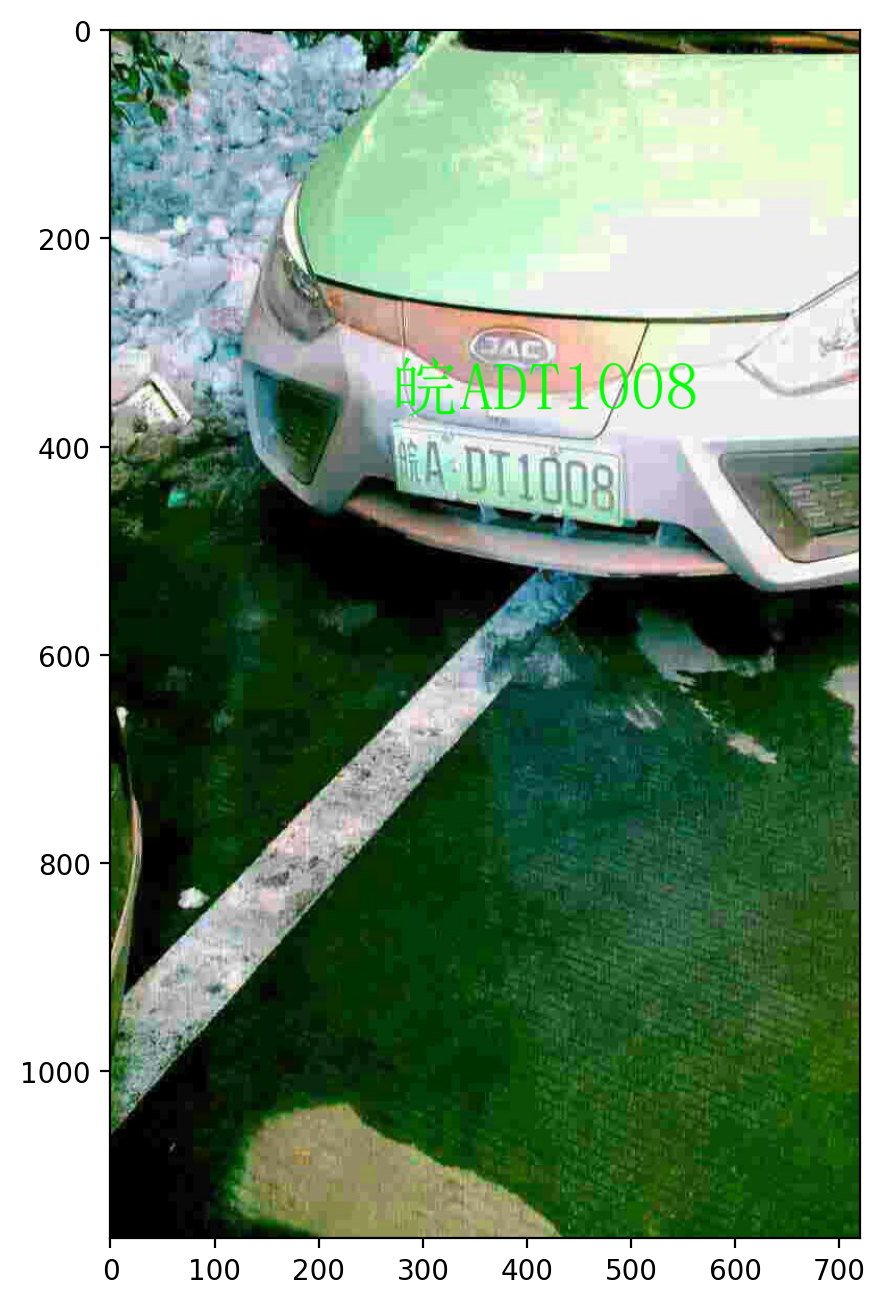

In [46]:
# 绘制文字信息
draw.text((int(point1[0]), int(point1[1])-70), "".join(result), font=font, fill=(0, 255, 0))
bk_img = np.array(img_pil)

plt.figure(figsize=(10, 8), dpi=200)
plt.imshow(bk_img)